# Mixed States Reconstruction (Infidelity as loss)

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [2]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation (Haar Distribution)

In [3]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [5]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [6]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand()**(1/3)* bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [7]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [8]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [9]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [10]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [11]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [12]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [13]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [14]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [15]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [16]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [31]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [32]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [33]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [34]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [35]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [36]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:900], bloch_vectors_with_noise[900:950], bloch_vectors_with_noise[950:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:900], bloch_vectors_noise_free[900:950], bloch_vectors_noise_free[950:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [37]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [38]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a*b
  return output

In [39]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(32, activation='relu')(input_layer1)
#x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x) #con sigmoid processo stabile, con ReLU instabile, con niente fidelity più alta
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 32)           128         ['input_3[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 16)           528         ['dense_2[0][0]']                
                                                                                                  
 vector (Dense)                 (None, 3)            51          ['dense_3[0][0]']                
                                                                                            

In [40]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.00005)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=180, epochs=4000)

Epoch 1/4000
5/5 [==============================] - 2s 77ms/step - loss: 0.1760 - val_loss: 0.1901
Epoch 2/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.1744 - val_loss: 0.1883
Epoch 3/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.1728 - val_loss: 0.1865
Epoch 4/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.1713 - val_loss: 0.1847
Epoch 5/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.1698 - val_loss: 0.1830
Epoch 6/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.1683 - val_loss: 0.1813
Epoch 7/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.1669 - val_loss: 0.1797
Epoch 8/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.1655 - val_loss: 0.1782
Epoch 9/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.1642 - val_loss: 0.1768
Epoch 10/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.1629 - val_loss: 0.1754
Epoch 11/

5/5 [==============================] - 0s 16ms/step - loss: 0.1198 - val_loss: 0.1257
Epoch 84/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.1193 - val_loss: 0.1252
Epoch 85/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.1189 - val_loss: 0.1248
Epoch 86/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.1184 - val_loss: 0.1243
Epoch 87/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.1179 - val_loss: 0.1237
Epoch 88/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.1174 - val_loss: 0.1231
Epoch 89/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.1169 - val_loss: 0.1226
Epoch 90/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.1164 - val_loss: 0.1221
Epoch 91/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.1159 - val_loss: 0.1216
Epoch 92/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.1154 - val_loss: 0.1212
Epoch 93/4000


5/5 [==============================] - 0s 26ms/step - loss: 0.0776 - val_loss: 0.0818
Epoch 165/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0771 - val_loss: 0.0811
Epoch 166/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0765 - val_loss: 0.0803
Epoch 167/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0760 - val_loss: 0.0795
Epoch 168/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0754 - val_loss: 0.0788
Epoch 169/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0750 - val_loss: 0.0781
Epoch 170/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0745 - val_loss: 0.0773
Epoch 171/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0740 - val_loss: 0.0766
Epoch 172/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0735 - val_loss: 0.0758
Epoch 173/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0730 - val_loss: 0.0751
Epoch

5/5 [==============================] - 0s 24ms/step - loss: 0.0446 - val_loss: 0.0401
Epoch 246/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0444 - val_loss: 0.0399
Epoch 247/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0443 - val_loss: 0.0396
Epoch 248/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0440 - val_loss: 0.0394
Epoch 249/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0439 - val_loss: 0.0391
Epoch 250/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0437 - val_loss: 0.0388
Epoch 251/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0435 - val_loss: 0.0386
Epoch 252/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0434 - val_loss: 0.0383
Epoch 253/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0432 - val_loss: 0.0381
Epoch 254/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0431 - val_loss: 0.0378
Epoch

5/5 [==============================] - 0s 17ms/step - loss: 0.0344 - val_loss: 0.0290
Epoch 327/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0343 - val_loss: 0.0290
Epoch 328/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0342 - val_loss: 0.0289
Epoch 329/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0341 - val_loss: 0.0288
Epoch 330/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0340 - val_loss: 0.0287
Epoch 331/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0339 - val_loss: 0.0287
Epoch 332/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0338 - val_loss: 0.0286
Epoch 333/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0337 - val_loss: 0.0285
Epoch 334/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0336 - val_loss: 0.0284
Epoch 335/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0335 - val_loss: 0.0284
Epoch

5/5 [==============================] - 0s 26ms/step - loss: 0.0276 - val_loss: 0.0242
Epoch 408/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0276 - val_loss: 0.0242
Epoch 409/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0275 - val_loss: 0.0241
Epoch 410/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0275 - val_loss: 0.0241
Epoch 411/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0274 - val_loss: 0.0240
Epoch 412/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0274 - val_loss: 0.0240
Epoch 413/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0273 - val_loss: 0.0239
Epoch 414/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0273 - val_loss: 0.0239
Epoch 415/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0272 - val_loss: 0.0238
Epoch 416/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0271 - val_loss: 0.0238
Epoch

5/5 [==============================] - 0s 26ms/step - loss: 0.0238 - val_loss: 0.0212
Epoch 489/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0237 - val_loss: 0.0212
Epoch 490/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0237 - val_loss: 0.0211
Epoch 491/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0237 - val_loss: 0.0211
Epoch 492/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0236 - val_loss: 0.0211
Epoch 493/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0236 - val_loss: 0.0210
Epoch 494/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 495/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 496/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 497/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0234 - val_loss: 0.0209
Epoch

5/5 [==============================] - 0s 27ms/step - loss: 0.0212 - val_loss: 0.0188
Epoch 570/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0212 - val_loss: 0.0188
Epoch 571/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0212 - val_loss: 0.0188
Epoch 572/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0212 - val_loss: 0.0188
Epoch 573/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0211 - val_loss: 0.0188
Epoch 574/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0211 - val_loss: 0.0188
Epoch 575/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0211 - val_loss: 0.0187
Epoch 576/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0211 - val_loss: 0.0187
Epoch 577/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0210 - val_loss: 0.0187
Epoch 578/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0210 - val_loss: 0.0187
Epoch

5/5 [==============================] - 0s 21ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 651/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 652/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 653/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 654/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 655/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0203 - val_loss: 0.0180
Epoch 656/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0203 - val_loss: 0.0180
Epoch 657/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0203 - val_loss: 0.0180
Epoch 658/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0203 - val_loss: 0.0180
Epoch 659/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch

5/5 [==============================] - 0s 32ms/step - loss: 0.0204 - val_loss: 0.0180
Epoch 732/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0204 - val_loss: 0.0180
Epoch 733/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0204 - val_loss: 0.0180
Epoch 734/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0204 - val_loss: 0.0179
Epoch 735/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0204 - val_loss: 0.0179
Epoch 736/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0204 - val_loss: 0.0179
Epoch 737/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0204 - val_loss: 0.0179
Epoch 738/4000
5/5 [==============================] - 0s 35ms/step - loss: 0.0204 - val_loss: 0.0179
Epoch 739/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0204 - val_loss: 0.0179
Epoch 740/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0204 - val_loss: 0.0179
Epoch

5/5 [==============================] - 0s 23ms/step - loss: 0.0205 - val_loss: 0.0178
Epoch 813/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0205 - val_loss: 0.0178
Epoch 814/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch 815/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0205 - val_loss: 0.0178
Epoch 816/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch 817/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch 818/4000
5/5 [==============================] - 0s 30ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch 819/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch 820/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch 821/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch

5/5 [==============================] - 0s 21ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 894/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 895/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 896/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 897/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 898/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 899/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 900/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch 901/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch 902/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch

5/5 [==============================] - 0s 24ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 975/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 976/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 977/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 978/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 979/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 980/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 981/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 982/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 983/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0219 - val_loss: 0.0190
Epoch

5/5 [==============================] - 0s 23ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 1055/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 1056/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 1057/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 1058/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 1059/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0229 - val_loss: 0.0199
Epoch 1060/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0229 - val_loss: 0.0199
Epoch 1061/4000
5/5 [==============================] - 0s 48ms/step - loss: 0.0229 - val_loss: 0.0199
Epoch 1062/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0229 - val_loss: 0.0199
Epoch 1063/4000
5/5 [==============================] - 0s 40ms/step - loss: 0.0229 - val_loss: 0.0

5/5 [==============================] - 0s 29ms/step - loss: 0.0240 - val_loss: 0.0209
Epoch 1135/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0241 - val_loss: 0.0209
Epoch 1136/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0241 - val_loss: 0.0209
Epoch 1137/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0241 - val_loss: 0.0209
Epoch 1138/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0241 - val_loss: 0.0209
Epoch 1139/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0241 - val_loss: 0.0210
Epoch 1140/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0241 - val_loss: 0.0210
Epoch 1141/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0242 - val_loss: 0.0210
Epoch 1142/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0242 - val_loss: 0.0210
Epoch 1143/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0242 - val_loss: 0.0

5/5 [==============================] - 0s 20ms/step - loss: 0.0254 - val_loss: 0.0221
Epoch 1215/4000
5/5 [==============================] - 0s 35ms/step - loss: 0.0254 - val_loss: 0.0221
Epoch 1216/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0254 - val_loss: 0.0221
Epoch 1217/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0255 - val_loss: 0.0222
Epoch 1218/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0255 - val_loss: 0.0222
Epoch 1219/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0255 - val_loss: 0.0223
Epoch 1220/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0255 - val_loss: 0.0223
Epoch 1221/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0255 - val_loss: 0.0222
Epoch 1222/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0255 - val_loss: 0.0222
Epoch 1223/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0255 - val_loss: 0.0

5/5 [==============================] - 0s 24ms/step - loss: 0.0267 - val_loss: 0.0234
Epoch 1295/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0267 - val_loss: 0.0234
Epoch 1296/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0268 - val_loss: 0.0234
Epoch 1297/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0268 - val_loss: 0.0234
Epoch 1298/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0268 - val_loss: 0.0234
Epoch 1299/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0268 - val_loss: 0.0235
Epoch 1300/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0268 - val_loss: 0.0235
Epoch 1301/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0269 - val_loss: 0.0236
Epoch 1302/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0269 - val_loss: 0.0236
Epoch 1303/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0269 - val_loss: 0.0

5/5 [==============================] - 0s 25ms/step - loss: 0.0278 - val_loss: 0.0247
Epoch 1375/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0279 - val_loss: 0.0247
Epoch 1376/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0279 - val_loss: 0.0247
Epoch 1377/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 1378/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 1379/4000
5/5 [==============================] - 0s 30ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 1380/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0280 - val_loss: 0.0248
Epoch 1381/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 1382/4000
5/5 [==============================] - 0s 30ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 1383/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0280 - val_loss: 0.0

5/5 [==============================] - 0s 27ms/step - loss: 0.0289 - val_loss: 0.0257
Epoch 1455/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0289 - val_loss: 0.0257
Epoch 1456/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0289 - val_loss: 0.0258
Epoch 1457/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0289 - val_loss: 0.0257
Epoch 1458/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0289 - val_loss: 0.0257
Epoch 1459/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0290 - val_loss: 0.0258
Epoch 1460/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0290 - val_loss: 0.0258
Epoch 1461/4000
5/5 [==============================] - 0s 44ms/step - loss: 0.0290 - val_loss: 0.0258
Epoch 1462/4000
5/5 [==============================] - 0s 40ms/step - loss: 0.0290 - val_loss: 0.0258
Epoch 1463/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0290 - val_loss: 0.0

5/5 [==============================] - 0s 27ms/step - loss: 0.0299 - val_loss: 0.0268
Epoch 1535/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0298 - val_loss: 0.0267
Epoch 1536/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0298 - val_loss: 0.0268
Epoch 1537/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0298 - val_loss: 0.0269
Epoch 1538/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0299 - val_loss: 0.0269
Epoch 1539/4000
5/5 [==============================] - 0s 30ms/step - loss: 0.0299 - val_loss: 0.0268
Epoch 1540/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0300 - val_loss: 0.0268
Epoch 1541/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0301 - val_loss: 0.0269
Epoch 1542/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0301 - val_loss: 0.0269
Epoch 1543/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0301 - val_loss: 0.0

5/5 [==============================] - 0s 32ms/step - loss: 0.0311 - val_loss: 0.0281
Epoch 1615/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0311 - val_loss: 0.0281
Epoch 1616/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0311 - val_loss: 0.0281
Epoch 1617/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0311 - val_loss: 0.0281
Epoch 1618/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0311 - val_loss: 0.0281
Epoch 1619/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0311 - val_loss: 0.0281
Epoch 1620/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0312 - val_loss: 0.0281
Epoch 1621/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0312 - val_loss: 0.0282
Epoch 1622/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0312 - val_loss: 0.0282
Epoch 1623/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0312 - val_loss: 0.0

5/5 [==============================] - 0s 28ms/step - loss: 0.0325 - val_loss: 0.0294
Epoch 1695/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0325 - val_loss: 0.0294
Epoch 1696/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0325 - val_loss: 0.0294
Epoch 1697/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0325 - val_loss: 0.0293
Epoch 1698/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0324 - val_loss: 0.0293
Epoch 1699/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0324 - val_loss: 0.0293
Epoch 1700/4000
5/5 [==============================] - 0s 51ms/step - loss: 0.0325 - val_loss: 0.0293
Epoch 1701/4000
5/5 [==============================] - 0s 46ms/step - loss: 0.0325 - val_loss: 0.0294
Epoch 1702/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0325 - val_loss: 0.0294
Epoch 1703/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0325 - val_loss: 0.0

5/5 [==============================] - 0s 35ms/step - loss: 0.0337 - val_loss: 0.0303
Epoch 1775/4000
5/5 [==============================] - 0s 35ms/step - loss: 0.0337 - val_loss: 0.0304
Epoch 1776/4000
5/5 [==============================] - 0s 46ms/step - loss: 0.0337 - val_loss: 0.0303
Epoch 1777/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0337 - val_loss: 0.0304
Epoch 1778/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0337 - val_loss: 0.0304
Epoch 1779/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0337 - val_loss: 0.0304
Epoch 1780/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0337 - val_loss: 0.0304
Epoch 1781/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0338 - val_loss: 0.0305
Epoch 1782/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0338 - val_loss: 0.0305
Epoch 1783/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0338 - val_loss: 0.0

5/5 [==============================] - 0s 23ms/step - loss: 0.0351 - val_loss: 0.0318
Epoch 1855/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0350 - val_loss: 0.0318
Epoch 1856/4000
5/5 [==============================] - 0s 51ms/step - loss: 0.0351 - val_loss: 0.0318
Epoch 1857/4000
5/5 [==============================] - 0s 35ms/step - loss: 0.0351 - val_loss: 0.0318
Epoch 1858/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0351 - val_loss: 0.0318
Epoch 1859/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0351 - val_loss: 0.0319
Epoch 1860/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0352 - val_loss: 0.0319
Epoch 1861/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0352 - val_loss: 0.0319
Epoch 1862/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0352 - val_loss: 0.0319
Epoch 1863/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0352 - val_loss: 0.0

5/5 [==============================] - 0s 20ms/step - loss: 0.0363 - val_loss: 0.0331
Epoch 1935/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0362 - val_loss: 0.0332
Epoch 1936/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0363 - val_loss: 0.0332
Epoch 1937/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0364 - val_loss: 0.0333
Epoch 1938/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0364 - val_loss: 0.0333
Epoch 1939/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0363 - val_loss: 0.0333
Epoch 1940/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0364 - val_loss: 0.0334
Epoch 1941/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0364 - val_loss: 0.0334
Epoch 1942/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0365 - val_loss: 0.0335
Epoch 1943/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0365 - val_loss: 0.0

5/5 [==============================] - 0s 22ms/step - loss: 0.0375 - val_loss: 0.0349
Epoch 2015/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0375 - val_loss: 0.0349
Epoch 2016/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0376 - val_loss: 0.0349
Epoch 2017/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0376 - val_loss: 0.0349
Epoch 2018/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0376 - val_loss: 0.0350
Epoch 2019/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0376 - val_loss: 0.0350
Epoch 2020/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0376 - val_loss: 0.0350
Epoch 2021/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0376 - val_loss: 0.0351
Epoch 2022/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0377 - val_loss: 0.0351
Epoch 2023/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0377 - val_loss: 0.0

5/5 [==============================] - 0s 21ms/step - loss: 0.0386 - val_loss: 0.0361
Epoch 2095/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0386 - val_loss: 0.0362
Epoch 2096/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0387 - val_loss: 0.0362
Epoch 2097/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0388 - val_loss: 0.0363
Epoch 2098/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0387 - val_loss: 0.0362
Epoch 2099/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0387 - val_loss: 0.0361
Epoch 2100/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0386 - val_loss: 0.0362
Epoch 2101/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0386 - val_loss: 0.0361
Epoch 2102/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0386 - val_loss: 0.0362
Epoch 2103/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0387 - val_loss: 0.0

5/5 [==============================] - 0s 25ms/step - loss: 0.0397 - val_loss: 0.0373
Epoch 2175/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0397 - val_loss: 0.0374
Epoch 2176/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0396 - val_loss: 0.0373
Epoch 2177/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0396 - val_loss: 0.0373
Epoch 2178/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0396 - val_loss: 0.0373
Epoch 2179/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0396 - val_loss: 0.0373
Epoch 2180/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0396 - val_loss: 0.0372
Epoch 2181/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0396 - val_loss: 0.0372
Epoch 2182/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0397 - val_loss: 0.0374
Epoch 2183/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0397 - val_loss: 0.0

5/5 [==============================] - 0s 25ms/step - loss: 0.0408 - val_loss: 0.0385
Epoch 2255/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0408 - val_loss: 0.0384
Epoch 2256/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0408 - val_loss: 0.0384
Epoch 2257/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0407 - val_loss: 0.0382
Epoch 2258/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0407 - val_loss: 0.0383
Epoch 2259/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0407 - val_loss: 0.0384
Epoch 2260/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0408 - val_loss: 0.0384
Epoch 2261/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0408 - val_loss: 0.0384
Epoch 2262/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0408 - val_loss: 0.0385
Epoch 2263/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0409 - val_loss: 0.0

5/5 [==============================] - 0s 19ms/step - loss: 0.0415 - val_loss: 0.0389
Epoch 2335/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0416 - val_loss: 0.0390
Epoch 2336/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0416 - val_loss: 0.0391
Epoch 2337/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0417 - val_loss: 0.0391
Epoch 2338/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0418 - val_loss: 0.0391
Epoch 2339/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0418 - val_loss: 0.0392
Epoch 2340/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0417 - val_loss: 0.0391
Epoch 2341/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0417 - val_loss: 0.0391
Epoch 2342/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0417 - val_loss: 0.0390
Epoch 2343/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0417 - val_loss: 0.0

5/5 [==============================] - 0s 22ms/step - loss: 0.0424 - val_loss: 0.0395
Epoch 2415/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0424 - val_loss: 0.0395
Epoch 2416/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0425 - val_loss: 0.0395
Epoch 2417/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0424 - val_loss: 0.0395
Epoch 2418/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0425 - val_loss: 0.0397
Epoch 2419/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0426 - val_loss: 0.0397
Epoch 2420/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0425 - val_loss: 0.0396
Epoch 2421/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0425 - val_loss: 0.0396
Epoch 2422/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0425 - val_loss: 0.0395
Epoch 2423/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0425 - val_loss: 0.0

5/5 [==============================] - 0s 20ms/step - loss: 0.0433 - val_loss: 0.0397
Epoch 2495/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0434 - val_loss: 0.0398
Epoch 2496/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0434 - val_loss: 0.0397
Epoch 2497/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0433 - val_loss: 0.0396
Epoch 2498/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0433 - val_loss: 0.0396
Epoch 2499/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0433 - val_loss: 0.0396
Epoch 2500/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0433 - val_loss: 0.0396
Epoch 2501/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0434 - val_loss: 0.0397
Epoch 2502/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0435 - val_loss: 0.0398
Epoch 2503/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0435 - val_loss: 0.0

5/5 [==============================] - 0s 21ms/step - loss: 0.0440 - val_loss: 0.0398
Epoch 2575/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0440 - val_loss: 0.0399
Epoch 2576/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0441 - val_loss: 0.0399
Epoch 2577/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0441 - val_loss: 0.0398
Epoch 2578/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0441 - val_loss: 0.0398
Epoch 2579/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0442 - val_loss: 0.0399
Epoch 2580/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0442 - val_loss: 0.0398
Epoch 2581/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0441 - val_loss: 0.0396
Epoch 2582/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0441 - val_loss: 0.0398
Epoch 2583/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0441 - val_loss: 0.0

5/5 [==============================] - 0s 37ms/step - loss: 0.0447 - val_loss: 0.0401
Epoch 2655/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0448 - val_loss: 0.0401
Epoch 2656/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0448 - val_loss: 0.0401
Epoch 2657/4000
5/5 [==============================] - 0s 35ms/step - loss: 0.0448 - val_loss: 0.0402
Epoch 2658/4000
5/5 [==============================] - 0s 42ms/step - loss: 0.0448 - val_loss: 0.0402
Epoch 2659/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0449 - val_loss: 0.0401
Epoch 2660/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0449 - val_loss: 0.0402
Epoch 2661/4000
5/5 [==============================] - 0s 36ms/step - loss: 0.0448 - val_loss: 0.0401
Epoch 2662/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0448 - val_loss: 0.0401
Epoch 2663/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0449 - val_loss: 0.0

5/5 [==============================] - 0s 27ms/step - loss: 0.0455 - val_loss: 0.0407
Epoch 2735/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0456 - val_loss: 0.0409
Epoch 2736/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0456 - val_loss: 0.0409
Epoch 2737/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0456 - val_loss: 0.0409
Epoch 2738/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0457 - val_loss: 0.0409
Epoch 2739/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0457 - val_loss: 0.0408
Epoch 2740/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0457 - val_loss: 0.0409
Epoch 2741/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0457 - val_loss: 0.0409
Epoch 2742/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0456 - val_loss: 0.0408
Epoch 2743/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0456 - val_loss: 0.0

5/5 [==============================] - 0s 19ms/step - loss: 0.0464 - val_loss: 0.0413
Epoch 2815/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0466 - val_loss: 0.0412
Epoch 2816/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0466 - val_loss: 0.0410
Epoch 2817/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0465 - val_loss: 0.0412
Epoch 2818/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0464 - val_loss: 0.0413
Epoch 2819/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0465 - val_loss: 0.0413
Epoch 2820/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0466 - val_loss: 0.0413
Epoch 2821/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0466 - val_loss: 0.0410
Epoch 2822/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0465 - val_loss: 0.0411
Epoch 2823/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0465 - val_loss: 0.0

5/5 [==============================] - 0s 19ms/step - loss: 0.0473 - val_loss: 0.0420
Epoch 2895/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0473 - val_loss: 0.0422
Epoch 2896/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0474 - val_loss: 0.0422
Epoch 2897/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0474 - val_loss: 0.0423
Epoch 2898/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0476 - val_loss: 0.0424
Epoch 2899/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0476 - val_loss: 0.0422
Epoch 2900/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0475 - val_loss: 0.0423
Epoch 2901/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0475 - val_loss: 0.0423
Epoch 2902/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0475 - val_loss: 0.0424
Epoch 2903/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0476 - val_loss: 0.0

5/5 [==============================] - 0s 20ms/step - loss: 0.0480 - val_loss: 0.0425
Epoch 2975/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0479 - val_loss: 0.0423
Epoch 2976/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0480 - val_loss: 0.0427
Epoch 2977/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0480 - val_loss: 0.0427
Epoch 2978/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0481 - val_loss: 0.0426
Epoch 2979/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0481 - val_loss: 0.0426
Epoch 2980/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0481 - val_loss: 0.0426
Epoch 2981/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0480 - val_loss: 0.0426
Epoch 2982/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0480 - val_loss: 0.0425
Epoch 2983/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0480 - val_loss: 0.0

5/5 [==============================] - 0s 21ms/step - loss: 0.0484 - val_loss: 0.0429
Epoch 3055/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0485 - val_loss: 0.0428
Epoch 3056/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0484 - val_loss: 0.0429
Epoch 3057/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0484 - val_loss: 0.0430
Epoch 3058/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0483 - val_loss: 0.0430
Epoch 3059/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0483 - val_loss: 0.0428
Epoch 3060/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0484 - val_loss: 0.0428
Epoch 3061/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0485 - val_loss: 0.0429
Epoch 3062/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0484 - val_loss: 0.0427
Epoch 3063/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0483 - val_loss: 0.0

5/5 [==============================] - 0s 23ms/step - loss: 0.0487 - val_loss: 0.0431
Epoch 3135/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0487 - val_loss: 0.0430
Epoch 3136/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0488 - val_loss: 0.0430
Epoch 3137/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0487 - val_loss: 0.0430
Epoch 3138/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0486 - val_loss: 0.0429
Epoch 3139/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0485 - val_loss: 0.0429
Epoch 3140/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0485 - val_loss: 0.0427
Epoch 3141/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0485 - val_loss: 0.0427
Epoch 3142/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0487 - val_loss: 0.0430
Epoch 3143/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0487 - val_loss: 0.0

5/5 [==============================] - 0s 19ms/step - loss: 0.0489 - val_loss: 0.0429
Epoch 3215/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0489 - val_loss: 0.0429
Epoch 3216/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0490 - val_loss: 0.0430
Epoch 3217/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0490 - val_loss: 0.0429
Epoch 3218/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0490 - val_loss: 0.0430
Epoch 3219/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0489 - val_loss: 0.0431
Epoch 3220/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0489 - val_loss: 0.0430
Epoch 3221/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0489 - val_loss: 0.0429
Epoch 3222/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0489 - val_loss: 0.0429
Epoch 3223/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0490 - val_loss: 0.0

5/5 [==============================] - 0s 22ms/step - loss: 0.0490 - val_loss: 0.0427
Epoch 3295/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0492 - val_loss: 0.0429
Epoch 3296/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0493 - val_loss: 0.0431
Epoch 3297/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0492 - val_loss: 0.0428
Epoch 3298/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0490 - val_loss: 0.0427
Epoch 3299/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0490 - val_loss: 0.0427
Epoch 3300/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0490 - val_loss: 0.0428
Epoch 3301/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0491 - val_loss: 0.0429
Epoch 3302/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0493 - val_loss: 0.0430
Epoch 3303/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0494 - val_loss: 0.0

5/5 [==============================] - 0s 20ms/step - loss: 0.0492 - val_loss: 0.0428
Epoch 3375/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0493 - val_loss: 0.0427
Epoch 3376/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0494 - val_loss: 0.0430
Epoch 3377/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0494 - val_loss: 0.0429
Epoch 3378/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0493 - val_loss: 0.0428
Epoch 3379/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0494 - val_loss: 0.0430
Epoch 3380/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0495 - val_loss: 0.0432
Epoch 3381/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0496 - val_loss: 0.0430
Epoch 3382/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0493 - val_loss: 0.0424
Epoch 3383/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0490 - val_loss: 0.0

5/5 [==============================] - 0s 31ms/step - loss: 0.0498 - val_loss: 0.0428
Epoch 3455/4000
5/5 [==============================] - 0s 30ms/step - loss: 0.0497 - val_loss: 0.0428
Epoch 3456/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0497 - val_loss: 0.0432
Epoch 3457/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0498 - val_loss: 0.0430
Epoch 3458/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0498 - val_loss: 0.0428
Epoch 3459/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0498 - val_loss: 0.0430
Epoch 3460/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0497 - val_loss: 0.0427
Epoch 3461/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0497 - val_loss: 0.0430
Epoch 3462/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0498 - val_loss: 0.0432
Epoch 3463/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0499 - val_loss: 0.0

5/5 [==============================] - 0s 27ms/step - loss: 0.0502 - val_loss: 0.0432
Epoch 3535/4000
5/5 [==============================] - 0s 30ms/step - loss: 0.0501 - val_loss: 0.0431
Epoch 3536/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0501 - val_loss: 0.0430
Epoch 3537/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0501 - val_loss: 0.0432
Epoch 3538/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0501 - val_loss: 0.0432
Epoch 3539/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0502 - val_loss: 0.0431
Epoch 3540/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0502 - val_loss: 0.0433
Epoch 3541/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0503 - val_loss: 0.0432
Epoch 3542/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0502 - val_loss: 0.0431
Epoch 3543/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0502 - val_loss: 0.0

5/5 [==============================] - 0s 34ms/step - loss: 0.0505 - val_loss: 0.0431
Epoch 3615/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0504 - val_loss: 0.0432
Epoch 3616/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0505 - val_loss: 0.0433
Epoch 3617/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0506 - val_loss: 0.0432
Epoch 3618/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0506 - val_loss: 0.0431
Epoch 3619/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0505 - val_loss: 0.0432
Epoch 3620/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0505 - val_loss: 0.0432
Epoch 3621/4000
5/5 [==============================] - 0s 36ms/step - loss: 0.0504 - val_loss: 0.0433
Epoch 3622/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0505 - val_loss: 0.0433
Epoch 3623/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0506 - val_loss: 0.0

5/5 [==============================] - 0s 31ms/step - loss: 0.0507 - val_loss: 0.0433
Epoch 3695/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0507 - val_loss: 0.0433
Epoch 3696/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0508 - val_loss: 0.0435
Epoch 3697/4000
5/5 [==============================] - 0s 26ms/step - loss: 0.0508 - val_loss: 0.0435
Epoch 3698/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0509 - val_loss: 0.0434
Epoch 3699/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0508 - val_loss: 0.0434
Epoch 3700/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0508 - val_loss: 0.0435
Epoch 3701/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0507 - val_loss: 0.0433
Epoch 3702/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0507 - val_loss: 0.0434
Epoch 3703/4000
5/5 [==============================] - 0s 37ms/step - loss: 0.0509 - val_loss: 0.0

5/5 [==============================] - 0s 29ms/step - loss: 0.0510 - val_loss: 0.0438
Epoch 3775/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0511 - val_loss: 0.0438
Epoch 3776/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0511 - val_loss: 0.0437
Epoch 3777/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0510 - val_loss: 0.0437
Epoch 3778/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0511 - val_loss: 0.0436
Epoch 3779/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0511 - val_loss: 0.0436
Epoch 3780/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0511 - val_loss: 0.0436
Epoch 3781/4000
5/5 [==============================] - 0s 39ms/step - loss: 0.0511 - val_loss: 0.0437
Epoch 3782/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0511 - val_loss: 0.0437
Epoch 3783/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0511 - val_loss: 0.0

5/5 [==============================] - 0s 33ms/step - loss: 0.0511 - val_loss: 0.0437
Epoch 3855/4000
5/5 [==============================] - 0s 36ms/step - loss: 0.0511 - val_loss: 0.0437
Epoch 3856/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0511 - val_loss: 0.0437
Epoch 3857/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0512 - val_loss: 0.0438
Epoch 3858/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0512 - val_loss: 0.0437
Epoch 3859/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0512 - val_loss: 0.0437
Epoch 3860/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0513 - val_loss: 0.0439
Epoch 3861/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0513 - val_loss: 0.0438
Epoch 3862/4000
5/5 [==============================] - 0s 36ms/step - loss: 0.0513 - val_loss: 0.0438
Epoch 3863/4000
5/5 [==============================] - 0s 33ms/step - loss: 0.0512 - val_loss: 0.0

5/5 [==============================] - 0s 37ms/step - loss: 0.0514 - val_loss: 0.0439
Epoch 3935/4000
5/5 [==============================] - 0s 31ms/step - loss: 0.0514 - val_loss: 0.0438
Epoch 3936/4000
5/5 [==============================] - 0s 27ms/step - loss: 0.0515 - val_loss: 0.0440
Epoch 3937/4000
5/5 [==============================] - 0s 34ms/step - loss: 0.0516 - val_loss: 0.0440
Epoch 3938/4000
5/5 [==============================] - 0s 32ms/step - loss: 0.0516 - val_loss: 0.0439
Epoch 3939/4000
5/5 [==============================] - 0s 28ms/step - loss: 0.0515 - val_loss: 0.0439
Epoch 3940/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0514 - val_loss: 0.0439
Epoch 3941/4000
5/5 [==============================] - 0s 29ms/step - loss: 0.0514 - val_loss: 0.0438
Epoch 3942/4000
5/5 [==============================] - 0s 37ms/step - loss: 0.0515 - val_loss: 0.0439
Epoch 3943/4000
5/5 [==============================] - 0s 30ms/step - loss: 0.0515 - val_loss: 0.0

In [41]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

2/2 - 0s - loss: 0.0469 - 60ms/epoch - 30ms/step


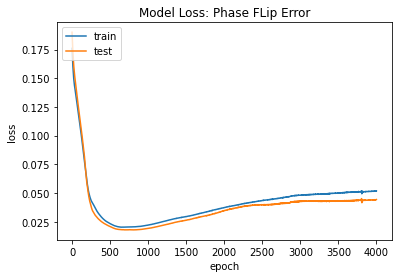

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.953136314275816-5.37291546234197e-09j), shape=(), dtype=complex128)
